In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

POINT_NUM_PER_TR = 500

In [2]:
# 确保定义的距离是有效的，非负性，同一性，对称性，直递性（三角不等式）
def dist(tr1,tr2):
    length = len(tr1)
    half = int(length/2)
    x1 = tr1[0:half]
    y1 = tr1[half:]
    x2 = tr2[0:half]
    y2 = tr2[half:]
    length = len(x1)
    deta_x = x1 - x2
    deta_y = y1 - y2
    distance = np.sum((deta_x**2 + deta_y**2) ** 0.5) / length
    # print(distance)
    return distance

In [3]:
# 将 DataFrame 封装成轨迹
# array([[x1,x2,...,x500,y1,y2,...,y500],[],...,[]])
def df2tr(df):
    x = np.array(df.loc[:,'x'])
    y = np.array(df.loc[:,'y'])
    trs = np.array([np.append(x[:POINT_NUM_PER_TR],y[:POINT_NUM_PER_TR],axis = 0).tolist()])
    for i in range(1,tr_num,1):
        start = i * POINT_NUM_PER_TR
        end = start + POINT_NUM_PER_TR
        trs = np.append(trs,np.array([np.append(x[start:end],y[start:end],axis = 0).tolist()]),axis = 0)
    return trs

In [4]:
from sklearn.neighbors import BallTree

# 设定 eps ，使得90%轨迹的最近邻距离小于 eps，且 eps 是满足条件的最小值
def get_eps(data):
    tree = BallTree(data, leaf_size=500,metric=dist)              
    dst, index = tree.query(data, k=2) 
    bin_num = 10
    eps = 0
    flag = True
    while flag:
        num, bin_edges = np.histogram(dst[:,1], bins = bin_num)
        for i in range(len(num)):
            sum = np.sum(num[:i+1])
            if sum/tr_num > 0.9:
                if np.abs(eps - bin_edges[i+1]) < 0.1:
                    flag = False
                eps = bin_edges[i+1]
                break
        bin_num = bin_num * 10
    return eps   

# 确定 min_samples，使得90%轨迹在 eps 内大于 min_samples，且 min_samples 是满足条件的最大值
def get_min_samples(data,eps):
    tree = BallTree(data, leaf_size=500,metric=dist) 
    samples_in_eps = tree.query_radius(data, r = eps, count_only=True)
    bin_num = 10
    min_samples = 0
    flag = True
    while flag:
        # x 表示某条轨迹在 eps 邻域内包含的点数，y ：比如，由 y 条轨迹，其 eps 邻域内的点数在【2，3】之间
        y, x = np.histogram(samples_in_eps,bins = bin_num)
        
        for i in range(len(y)):
            sum = np.sum(y[-(i+1):])
            if sum/tr_num > 0.9:
                if np.abs(min_samples - x[-(i+2)]) < 1:
                    flag = False
                min_samples = x[-(i+2)]
                break
        bin_num = bin_num * 10
    if (min_samples - int(min_samples)) < 0.5:
        return int(min_samples)
    else:
        return int(min_samples) + 1


In [5]:
from sklearn.cluster import DBSCAN
def cluster(data):
    eps = get_eps(data)
    min_samples = get_min_samples(data,eps)
    clustering = DBSCAN(eps = eps, min_samples = min_samples, metric = dist).fit(data)
    return clustering.labels_


In [6]:
df1 = pd.read_csv('./new_node1.csv')

tr_num = int(df1.shape[0] / POINT_NUM_PER_TR)



In [7]:
trs = df2tr(df1)

In [45]:
K = 12

In [46]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

metric = distance_metric(type_metric.USER_DEFINED, func=dist)
initial_centers = kmeans_plusplus_initializer(trs, K).initialize()

# create instance of K-Means using specific distance metric:
kmeans_instance = kmeans(trs, initial_centers, metric=metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

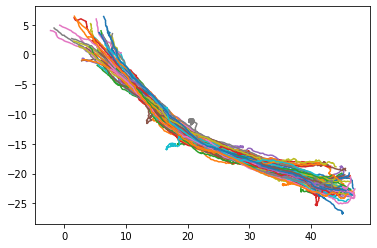

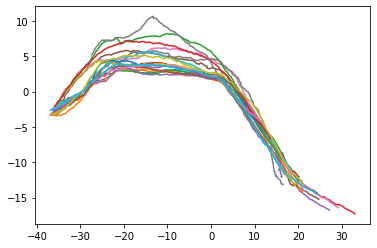

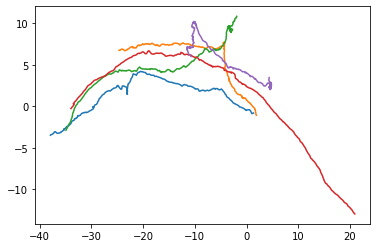

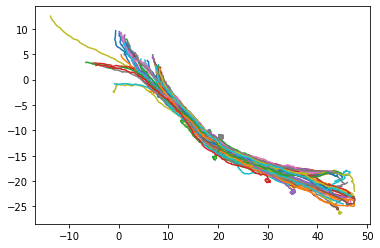

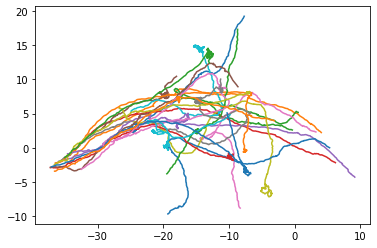

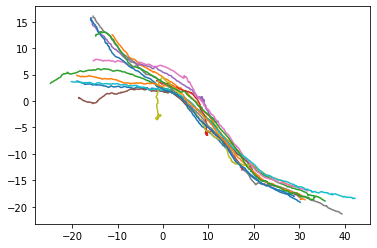

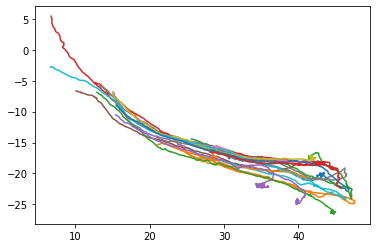

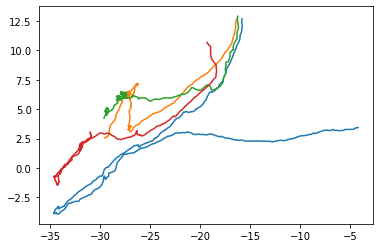

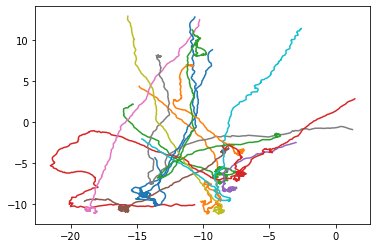

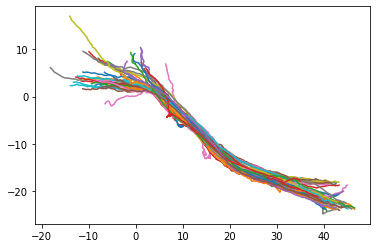

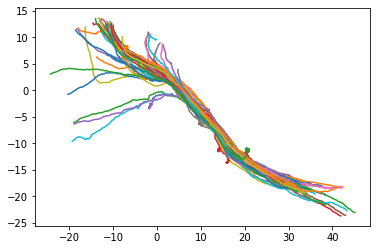

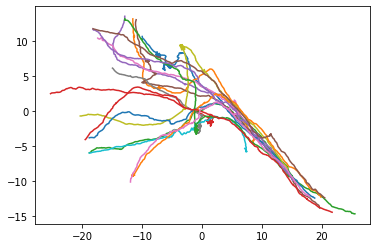

In [47]:
for i in range(K):
    cluster_i = trs[clusters[i]]
    for j in range(len(cluster_i)):
        plt.plot(cluster_i[j][:500],cluster_i[j][500:])
    plt.show()

In [220]:
tr_try = trs[clusters[1]]
tr_try = np.round(tr_try)
tr_point = [    [  (tr_try[j][i],tr_try[j][i+POINT_NUM_PER_TR])    for i in range(POINT_NUM_PER_TR)]     
                       for j in range(len(tr_try))]

In [221]:
# 离散化
# 没有数据隐私问题，不需要拟合，直接用折线图

In [222]:
len(tr_point[0])

500

In [223]:
# 去掉连续落在同一区间上的点

for i in range(len(tr_point)):
    tmp = []
    l = tr_point[i].copy()
    for j in range(POINT_NUM_PER_TR-1):
        if l[j] == l[j+1]:
            tmp.append(j)
    tr_point[i] = [l[i] for i in range(POINT_NUM_PER_TR) if i not in tmp]

In [224]:
for i in range(len(tr_point)):
    print(len(tr_point[i]))

75
72
78
94
90
85
87
78
75
76
72
83
88
71
72
71
90
73
82
89


In [225]:
for i in tr_point:
    print(i,len(i))

[(-36.0, -2.0), (-35.0, -2.0), (-34.0, -2.0), (-33.0, -2.0), (-33.0, -1.0), (-32.0, -1.0), (-31.0, -1.0), (-30.0, 0.0), (-29.0, 0.0), (-29.0, 1.0), (-28.0, 1.0), (-27.0, 1.0), (-26.0, 1.0), (-26.0, 2.0), (-25.0, 2.0), (-24.0, 2.0), (-23.0, 2.0), (-23.0, 3.0), (-22.0, 3.0), (-21.0, 3.0), (-20.0, 3.0), (-19.0, 3.0), (-18.0, 3.0), (-17.0, 3.0), (-16.0, 3.0), (-15.0, 3.0), (-14.0, 3.0), (-13.0, 3.0), (-12.0, 3.0), (-11.0, 3.0), (-10.0, 3.0), (-9.0, 3.0), (-8.0, 3.0), (-7.0, 3.0), (-6.0, 3.0), (-5.0, 3.0), (-4.0, 2.0), (-3.0, 2.0), (-2.0, 2.0), (-1.0, 2.0), (0.0, 2.0), (1.0, 2.0), (2.0, 2.0), (2.0, 1.0), (3.0, 1.0), (4.0, 1.0), (4.0, 0.0), (5.0, -0.0), (5.0, -1.0), (6.0, -1.0), (6.0, -2.0), (7.0, -2.0), (8.0, -2.0), (8.0, -3.0), (9.0, -3.0), (9.0, -4.0), (10.0, -4.0), (11.0, -4.0), (11.0, -5.0), (12.0, -5.0), (12.0, -6.0), (13.0, -6.0), (14.0, -6.0), (14.0, -7.0), (15.0, -7.0), (15.0, -8.0), (16.0, -8.0), (16.0, -9.0), (17.0, -9.0), (17.0, -10.0), (18.0, -10.0), (18.0, -11.0), (19.0, -11.0)

In [226]:
# 防止出现跨越的点
for i in range(len(tr_point)):
    tmp = tr_point[i].copy()  # [(),(),...,()]
    count = 0 # 添加的点造成的偏移
    for j in range(len(tmp) - 1):
        now_p = tmp[j]
        next_p = tmp[j + 1]
        if not(tr_point[i][j + count] == now_p and tr_point[i][j + count + 1] == next_p):
            print('WRONGGGGG: ',now_p,next_p,tr_point[i][j + count],tr_point[i][j + count],)
            break
        if now_p[0] == next_p[0] and abs(now_p[1] - next_p[1]) == 1:
            continue
        elif abs(now_p[0] - next_p[0]) == 1 and now_p[1] == next_p[1]:
            continue   
        else:
            print(now_p,next_p)
            delta_x = int(abs(now_p[0] - next_p[0]))
            delta_y = int(abs(now_p[1] - next_p[1]))
            if delta_x == 0:
                step = (next_p[1] - now_p[1]) / delta_y
                for k in range(1,delta_y,1):
                    tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                count = count + delta_y - 1
                continue
            elif delta_y == 0:
                step = (next_p[0] - now_p[0])/delta_x
                for k in range(1,delta_x,1):
                    tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                count = count + delta_x - 1
                continue
            else:
                step_x = (next_p[0] - now_p[0])/delta_x
                step_y = (next_p[1] - now_p[1]) / delta_y
                k = 1
                while delta_x != 0 and delta_y != 0:
                    tr_point[i].insert(j + count + 1,(now_p[0] + k * step_x,now_p[1]))
                    tr_point[i].insert(j + count + 2,(now_p[0] + k * step_x,now_p[1] + k * step_y))
                    count = count + 2
                    k = k + 1
                    delta_x = delta_x - 1
                    delta_y = delta_y - 1
                if delta_x == 0 and delta_y == 0:
                    tr_point[i].pop(j + count)
                    count = count - 1
                elif delta_x == 0:
                    step = (next_p[1] - now_p[1]) / delta_y
                    for k in range(1,delta_y,1):
                        tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                    count = count + delta_y - 1
                    continue
                elif delta_y == 0:
                    step = (next_p[0] - now_p[0])/delta_x
                    for k in range(1,delta_x,1):
                        tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                    count = count + delta_x - 1
                    continue

(-31.0, -1.0) (-30.0, 0.0)
(-5.0, 3.0) (-4.0, 2.0)
(6.0, -0.0) (7.0, -1.0)
(4.0, 1.0) (5.0, 0.0)
(-31.0, -1.0) (-30.0, -0.0)
(-25.0, 3.0) (-24.0, 4.0)
(17.0, -10.0) (18.0, -11.0)
(19.0, -11.0) (20.0, -12.0)
(24.0, -14.0) (25.0, -15.0)
(27.0, -15.0) (28.0, -16.0)
(-31.0, -1.0) (-30.0, -0.0)
(9.0, -4.0) (10.0, -5.0)
(10.0, -5.0) (11.0, -6.0)
(26.0, -16.0) (27.0, -17.0)
(-34.0, -1.0) (-33.0, 0.0)
(-30.0, 2.0) (-29.0, 3.0)
(-22.0, 5.0) (-21.0, 6.0)
(4.0, 2.0) (5.0, 1.0)
(14.0, -7.0) (15.0, -8.0)
(-23.0, 4.0) (-22.0, 5.0)
(18.0, -11.0) (19.0, -12.0)
(-3.0, 4.0) (-2.0, 5.0)
(-33.0, 0.0) (-32.0, 1.0)
(-28.0, 3.0) (-27.0, 4.0)
(-2.0, 3.0) (-1.0, 2.0)
(18.0, -12.0) (19.0, -13.0)
(-29.0, 0.0) (-28.0, 1.0)
(-27.0, 2.0) (-26.0, 3.0)
(-25.0, 3.0) (-24.0, 4.0)
(-9.0, 5.0) (-8.0, 4.0)
(2.0, 2.0) (3.0, 1.0)
(8.0, -2.0) (9.0, -3.0)
(3.0, 2.0) (4.0, 1.0)
(8.0, -2.0) (9.0, -3.0)
(9.0, -3.0) (10.0, -4.0)
(12.0, -6.0) (13.0, -7.0)
(-30.0, -0.0) (-29.0, -1.0)
(5.0, -0.0) (6.0, -1.0)
(8.0, -3.0) (9.0, -4.0)


In [227]:
for i in tr_point:
    print(i,len(i))

[(-36.0, -2.0), (-35.0, -2.0), (-34.0, -2.0), (-33.0, -2.0), (-33.0, -1.0), (-32.0, -1.0), (-31.0, -1.0), (-30.0, -1.0), (-30.0, 0.0), (-29.0, 0.0), (-29.0, 1.0), (-28.0, 1.0), (-27.0, 1.0), (-26.0, 1.0), (-26.0, 2.0), (-25.0, 2.0), (-24.0, 2.0), (-23.0, 2.0), (-23.0, 3.0), (-22.0, 3.0), (-21.0, 3.0), (-20.0, 3.0), (-19.0, 3.0), (-18.0, 3.0), (-17.0, 3.0), (-16.0, 3.0), (-15.0, 3.0), (-14.0, 3.0), (-13.0, 3.0), (-12.0, 3.0), (-11.0, 3.0), (-10.0, 3.0), (-9.0, 3.0), (-8.0, 3.0), (-7.0, 3.0), (-6.0, 3.0), (-5.0, 3.0), (-4.0, 3.0), (-4.0, 2.0), (-3.0, 2.0), (-2.0, 2.0), (-1.0, 2.0), (0.0, 2.0), (1.0, 2.0), (2.0, 2.0), (2.0, 1.0), (3.0, 1.0), (4.0, 1.0), (4.0, 0.0), (5.0, -0.0), (5.0, -1.0), (6.0, -1.0), (6.0, -2.0), (7.0, -2.0), (8.0, -2.0), (8.0, -3.0), (9.0, -3.0), (9.0, -4.0), (10.0, -4.0), (11.0, -4.0), (11.0, -5.0), (12.0, -5.0), (12.0, -6.0), (13.0, -6.0), (14.0, -6.0), (14.0, -7.0), (15.0, -7.0), (15.0, -8.0), (16.0, -8.0), (16.0, -9.0), (17.0, -9.0), (17.0, -10.0), (18.0, -10.0), 

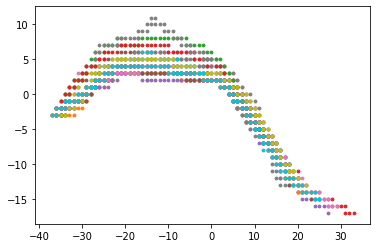

In [345]:
for i in  tr_point:
    x = [point[0] for point in i]
    y = [point[1] for point in i]
    plt.scatter(x,y,8)
plt.show()

In [346]:
# 马尔科夫模型
all_point = []
for i in tr_point:
    for j in range(len(i)):
        all_point.append(i[j])
all_point = set(all_point)

In [347]:
all_point = list(all_point)

In [348]:
prob = np.zeros((362,362))
trans_matrix = pd.DataFrame(prob,columns = pd.MultiIndex.from_tuples(all_point),  index = pd.MultiIndex.from_tuples(all_point))

In [349]:
trans_matrix

,,-22.0,-17.0,-29.0,-33.0,9.0,-28.0,-14.0,14.0,3.0,-9.0,...,-30.0,-6.0,-2.0,-25.0,-16.0,13.0,-13.0,-12.0,-11.0,-24.0
,,7.0,4.0,2.0,-3.0,-0.0,5.0,10.0,-10.0,2.0,9.0,...,-0.0,5.0,7.0,3.0,9.0,-6.0,4.0,7.0,6.0,5.0
-22.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-29.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-33.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-13.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [350]:
for i in tr_point:
    for j in range(len(i) - 1):
        now_p = i[j]
        next_p = i[j + 1]
        trans_matrix.loc[now_p,next_p] = trans_matrix.loc[now_p,next_p] + 1

In [351]:
trans_matrix.loc[(-36.0, -2.0),(-35.0, -2.0)]

9.0

In [352]:
for i in range(len(trans_matrix)):
    trans_matrix.iloc[i] = trans_matrix.iloc[i] / sum(trans_matrix.iloc[i])


In [354]:
np.array(trans_matrix.loc[(-36.0,-3.0)])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.72727273, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [380]:
print(trans_matrix.isnull().any())

-22.0   7.0    True
-17.0   4.0    True
-29.0   2.0    True
-33.0  -3.0    True
 9.0   -0.0    True
               ... 
 13.0  -6.0    True
-13.0   4.0    True
-12.0   7.0    True
-11.0   6.0    True
-24.0   5.0    True
Length: 362, dtype: bool


In [355]:
n = np.random.choice(len(all_point),1,p = list(trans_matrix.loc[(-36.0,-3.0)]))
all_point[n[0]]

(-35.0, -3.0)

In [358]:
np.array(trans_matrix.loc[(-36.0,-3.0)])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.72727273, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

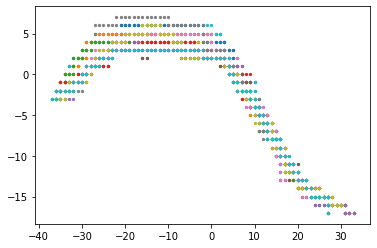

In [416]:
def gen():
    for tr in tr_point:
        gen_tr = []
        now_p = tr[0]
        gen_tr.append(now_p)
        for i in range(100):
            pro = list(trans_matrix.loc[now_p])
            if np.isnan(pro[0]):
                break
            n = np.random.choice(len(all_point),1,p = pro)
            gen_tr.append(all_point[n[0]])
            now_p = all_point[n[0]]
        gen_x = [p[0] for p in gen_tr]
        gen_y = [p[1] for p in gen_tr]
        plt.scatter(gen_x,gen_y,5)
    


    
gen()
plt.show()